# Neural Style Transfer

We'll perform style transfer between images.

## Select Content Image

We begin by loading the example image titled `neuraltissue_with_colorlabels.png`, of which we crop a patch of 256 by 256 pixels.

This image is sourced from the Drosophila ssTEM dataset, which is publicly available on Figshare: [Segmented anisotropic ssTEM dataset of neural tissue](https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713). This dataset provides a detailed view of neural tissue, aiding in the study of neural structures and patterns. The image can also be downloaded from the corresponding GitHub repository at [this link](http://github.com/unidesigner/groundtruth-drosophila-vnc), which offers additional resources and information related to the Drosophila ssTEM dataset.

In [1]:
from PIL import Image

content = (
    Image.open("neuraltissue_with_colorlabels.png")
    .convert("RGB")
    .crop((100, 170, 100 + 256, 170 + 256))
)

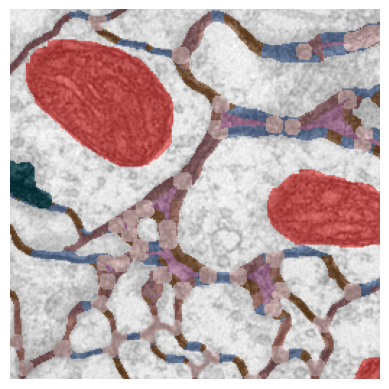

In [2]:
from matplotlib import pyplot as plt

plt.imshow(content)
plt.axis("off")
plt.show()


## Select Style Image

We use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona) in the image `lizard.png`.

In [3]:
style = Image.open("lizard.png").convert("RGB").resize((256, 256))

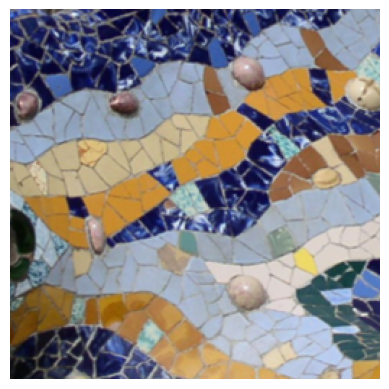

In [4]:
plt.imshow(style)
plt.axis("off")
plt.show()

## Load Pretrained Neural Network

We import the VGG16 model, a pretrained neural network known for its proficiency in image recognition tasks, with weights initialized from the ImageNet dataset. We then set the model to evaluation mode and freeze all weights to prevent further changes during our operations.

In [5]:
import torchvision.models as models
from torchvision.models import VGG16_Weights

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

model.eval()
model.requires_grad_(False)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Implement Style Transfer

We'll define a function that minimize the style and content losses with respect to the reference images. 

We define a function for calculating the Gram matrix between all the activations of a specific layer.
The Gram matrix represents the correlations between different feature maps (or channels) of the output of a convolutional layer.

This is the `gram()` function and add it to `fnc_style_transfer.py`:
```python
def gram(tensor):
    from torch import bmm
    
    batch_size, num_channels, height, width = tensor.size()
    activations = tensor.view(batch_size, num_channels, height * width)
    gram = bmm(activations, activations.transpose(1, 2)) / (height * width)

    return gram
```
This function:
- Unpacks the dimensions of the input tensor
- Reshapes the tensor so it's a 2D matrix, with channels as activations and height*width as observations
- Computes the Gram matrix as the product of the matrix by its transpose, normalizing by the number of elements in each feature map (`height * width`)

We also add the `image_to_tensor()` function to `fnc_style_transfer.py` (the same function as for the DeepDream project).
```python
def image_to_tensor(im, mean, std):
    import torchvision.transforms as tt

    normalize = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)])

    return normalize(im).unsqueeze(0).requires_grad_(True)
```

We also add the `tensor_to_image()` function to `fnc_style_transfer.py` (the same function as for the DeepDream project).
```python
def tensor_to_image(image, mean, std):
    import torchvision.transforms as tt
    import numpy as np
    from PIL import Image

    denormalize = tt.Normalize(mean=-mean / std, std=1 / std)

    im_array = denormalize(image.data.clone().detach().squeeze()).numpy()
    im_array = np.clip(im_array.transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(im_array, 'RGB')
```

We also add the `Fwd_Hooks()` function to `fnc_style_transfer.py` (the same function as for the DeepDream project).

```python
class Fwd_Hooks():
    def __init__(self, layers):
        self.hooks = []
        self.activations_list = []
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(self.hook_func))

    def hook_func(self, layer, input, output):
        self.activations_list.append(output)

    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        for hook in self.hooks:
            hook.remove()
```

We finally implement the `style_transfer()` function.

The `style_transfer()` function performs style transfer on images using neural networks, a technique where an image is created from the style of one image (e.g., an image of the texture of Gaudi's lizard) and the content of another (e.g., an image of neural tissue). The function accepts an image, content, and style inputs, along with parameters defining layers in a neural network model, learning rate (`lr`), a regularization parameter (`beta`), and the number of iterations. It normalizes the input images and converts them into tensors. The function then extracts activations from the specified content and style layers using a model and computes Gram matrices for style representations. An optimizer is set up to minimize a loss function, which is a combination of content loss (how much the transformed image deviates from the content in the content image) and style loss (how different the style of the transformed image is from the style image), with the style loss being scaled by `beta`. During optimization, the function iteratively updates the image to minimize the total loss, displaying the intermediate results at specified intervals. The final transformed image is returned at the end of the function.

In [6]:
import numpy as np
import torch
from fnc_style_transfer import gram, image_to_tensor, tensor_to_image, Fwd_Hooks

def style_transfer(image, content, style, content_layers, style_layers, 
                   lr=1, beta=1e3, iter_num=100):
    # Normalization parameters typically used with pretrained models
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    # input image
    image_tensor = image_to_tensor(image, mean, std)  # .requires_grad_(True)

    # content
    with Fwd_Hooks(content_layers) as fh:
        _ = model(image_to_tensor(content, mean, std))
    content_activations = [activations.detach() for activations in fh.activations_list]

    # style
    with Fwd_Hooks(style_layers) as fh:
        _ = model(image_to_tensor(style, mean, std))
    gram_targets = [gram(activations.detach()) for activations in fh.activations_list]

    optimizer = torch.optim.LBFGS([image_tensor], lr=lr)
    mse_loss = torch.nn.MSELoss(reduction="sum")

    def closure():
        optimizer.zero_grad()

        # content
        with Fwd_Hooks(content_layers) as fh:
            _ = model(image_tensor)
        image_content_activations = fh.activations_list

        content_loss = 0
        for ia, ca in zip(image_content_activations, content_activations):
            n_f = ia.shape[1]
            content_loss += mse_loss(ia, ca) / n_f**2
        content_loss /= len(image_content_activations)

        # style
        with Fwd_Hooks(style_layers) as fh:
            _ = model(image_tensor)
        gram_image = [gram(activations) for activations in fh.activations_list]

        style_loss = 0
        for gi, gt in zip(gram_image, gram_targets):
            n_g = gi.shape[1]
            style_loss += mse_loss(gi, gt) / n_g**2
        style_loss /= len(gram_image)

        print(f"content_loss={content_loss} style_loss={style_loss}")

        total_loss = content_loss + beta * style_loss
        total_loss.backward()
        return total_loss

    for i in range(iter_num):
        print(f"iteration {i}")

        optimizer.step(closure)

        image = tensor_to_image(image_tensor, mean, std)

        if i <= 5 or i % 10 == 0 or i == iter_num - 1:
            plt.imshow(image)
            plt.title(f"Iteration {i}")
            plt.axis("off")
            plt.show()

    return image

## Apply Style Transform

We start by writing a `plot_style_transform()` function to plot side-by-side content image, style image, and trnasformed image.

In [7]:
def plot_style_transform(content, style, image):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(content)
    plt.title("Content image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(style)
    plt.title("Style image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.title("Output image")
    plt.axis("off")

    plt.show()

We first apply it with a random image as starting point.

iteration 0
content_loss=329.30108642578125 style_loss=228.4657745361328
content_loss=329.29925537109375 style_loss=228.4508514404297
content_loss=299.520751953125 style_loss=64.78172302246094
content_loss=288.31097412109375 style_loss=40.963619232177734
content_loss=274.1273193359375 style_loss=19.261159896850586
content_loss=267.2549133300781 style_loss=10.279519081115723
content_loss=268.259765625 style_loss=5.896955966949463
content_loss=288.082275390625 style_loss=3.6534290313720703
content_loss=330.8211975097656 style_loss=2.3036842346191406
content_loss=354.8919677734375 style_loss=1.6264381408691406
content_loss=353.4951171875 style_loss=1.2230556011199951
content_loss=364.86175537109375 style_loss=0.9634904861450195
content_loss=339.9803466796875 style_loss=0.8551780581474304
content_loss=348.4093017578125 style_loss=0.7174781560897827
content_loss=351.0272216796875 style_loss=0.6323965787887573
content_loss=341.1024169921875 style_loss=0.5696719288825989
content_loss=343.4823

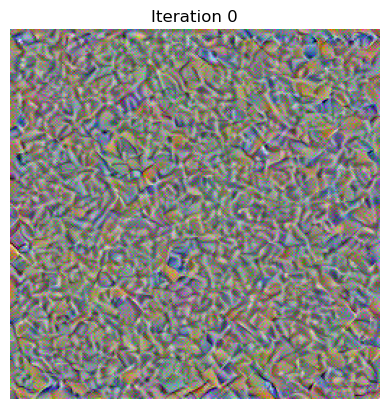

iteration 1
content_loss=324.667724609375 style_loss=0.3333505690097809
content_loss=324.4169616699219 style_loss=0.3002026677131653
content_loss=319.397216796875 style_loss=0.2801300585269928
content_loss=314.46234130859375 style_loss=0.2557685971260071
content_loss=312.340576171875 style_loss=0.2340482771396637
content_loss=303.8100280761719 style_loss=0.22800910472869873
content_loss=302.8857116699219 style_loss=0.21023952960968018
content_loss=302.85321044921875 style_loss=0.19770853221416473
content_loss=295.8070068359375 style_loss=0.19609208405017853
content_loss=295.0284423828125 style_loss=0.1849442422389984
content_loss=292.17254638671875 style_loss=0.17527130246162415
content_loss=285.7309875488281 style_loss=0.17033381760120392
content_loss=286.51141357421875 style_loss=0.15930387377738953
content_loss=281.141845703125 style_loss=0.16052119433879852
content_loss=280.4864196777344 style_loss=0.15381565690040588
content_loss=277.14794921875 style_loss=0.14658626914024353
cont

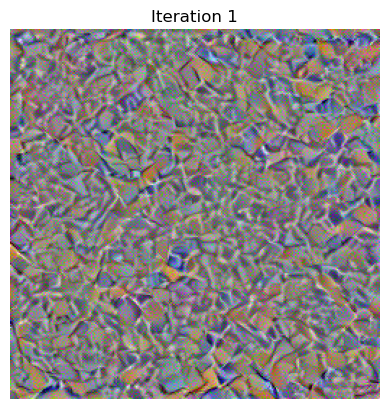

iteration 2
content_loss=261.026123046875 style_loss=0.12330572307109833
content_loss=255.42156982421875 style_loss=0.12159430980682373
content_loss=254.24578857421875 style_loss=0.11583578586578369
content_loss=251.338134765625 style_loss=0.11347074806690216
content_loss=244.9414825439453 style_loss=0.1126973032951355
content_loss=246.06973266601562 style_loss=0.10679254680871964
content_loss=243.27732849121094 style_loss=0.10679073631763458
content_loss=241.38648986816406 style_loss=0.1052858978509903
content_loss=238.47218322753906 style_loss=0.10361298173666
content_loss=236.56785583496094 style_loss=0.09949703514575958
content_loss=233.60244750976562 style_loss=0.09788545221090317
content_loss=228.95822143554688 style_loss=0.09724770486354828
content_loss=229.1395263671875 style_loss=0.09308765828609467
content_loss=226.5806427001953 style_loss=0.09355349838733673
content_loss=226.4862518310547 style_loss=0.09119728952646255
content_loss=224.28662109375 style_loss=0.09025627374649

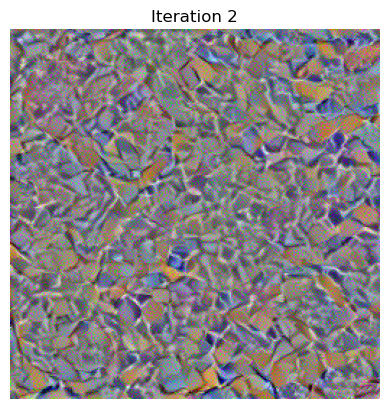

iteration 3
content_loss=215.6721649169922 style_loss=0.08312888443470001
content_loss=214.3171844482422 style_loss=0.08249421417713165
content_loss=207.77117919921875 style_loss=0.09042365849018097
content_loss=211.08416748046875 style_loss=0.0796448141336441
content_loss=210.1673126220703 style_loss=0.07930056750774384
content_loss=203.8350830078125 style_loss=0.08568359911441803
content_loss=206.34373474121094 style_loss=0.07777915894985199
content_loss=205.5699005126953 style_loss=0.07702064514160156
content_loss=201.09796142578125 style_loss=0.07870258390903473
content_loss=201.5055694580078 style_loss=0.07472661882638931
content_loss=200.69082641601562 style_loss=0.07392548024654388
content_loss=196.64691162109375 style_loss=0.07512692362070084
content_loss=196.98419189453125 style_loss=0.07170145213603973
content_loss=195.51502990722656 style_loss=0.0716814175248146
content_loss=191.1345672607422 style_loss=0.07382019609212875
content_loss=191.8391876220703 style_loss=0.06981631

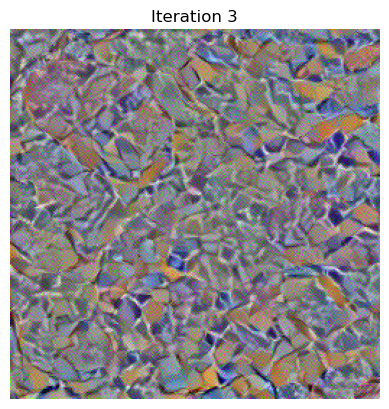

iteration 4
content_loss=182.61279296875 style_loss=0.06913603842258453
content_loss=183.9036102294922 style_loss=0.06517703831195831
content_loss=183.40147399902344 style_loss=0.06449605524539948
content_loss=181.4837646484375 style_loss=0.06465606391429901
content_loss=179.96847534179688 style_loss=0.06402241438627243
content_loss=178.41114807128906 style_loss=0.06297897547483444
content_loss=177.45567321777344 style_loss=0.061640482395887375
content_loss=175.18406677246094 style_loss=0.061869584023952484
content_loss=174.2937469482422 style_loss=0.06060035154223442
content_loss=173.2464141845703 style_loss=0.059697188436985016
content_loss=170.6279296875 style_loss=0.060141097754240036
content_loss=170.47848510742188 style_loss=0.05851836875081062
content_loss=169.63510131835938 style_loss=0.05797917768359184
content_loss=167.15264892578125 style_loss=0.05843827873468399
content_loss=167.1939239501953 style_loss=0.056829262524843216
content_loss=166.33795166015625 style_loss=0.05661

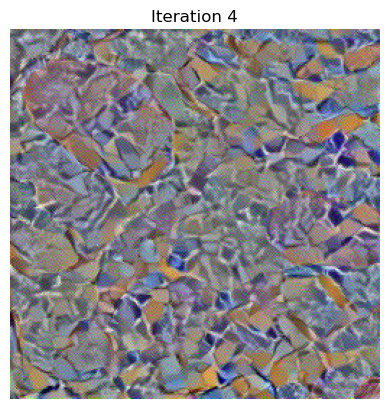

iteration 5
content_loss=161.3993377685547 style_loss=0.05463055521249771
content_loss=160.6827850341797 style_loss=0.054381661117076874
content_loss=158.55963134765625 style_loss=0.054989419877529144
content_loss=158.8502655029297 style_loss=0.0531935915350914
content_loss=158.16171264648438 style_loss=0.053135134279727936
content_loss=156.54022216796875 style_loss=0.05367036536335945
content_loss=156.2385711669922 style_loss=0.052629899233579636
content_loss=155.3726043701172 style_loss=0.05220147967338562
content_loss=154.72119140625 style_loss=0.05192151665687561
content_loss=153.86807250976562 style_loss=0.05153689533472061
content_loss=152.97653198242188 style_loss=0.051150739192962646
content_loss=152.2419891357422 style_loss=0.050564974546432495
content_loss=150.85345458984375 style_loss=0.0507248230278492
content_loss=150.55322265625 style_loss=0.0498216338455677
content_loss=149.80438232421875 style_loss=0.04954509809613228
content_loss=148.5424346923828 style_loss=0.04957745

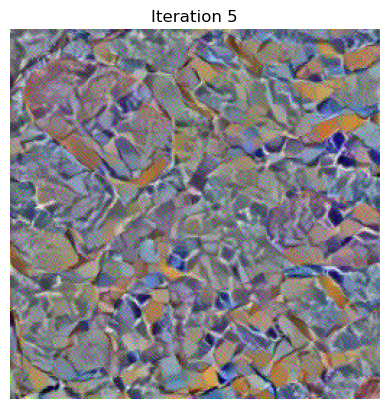

iteration 6
content_loss=145.59890747070312 style_loss=0.04776311665773392
content_loss=144.7132110595703 style_loss=0.04753674566745758
content_loss=144.31727600097656 style_loss=0.04687966778874397
content_loss=143.54412841796875 style_loss=0.04672352597117424
content_loss=142.42636108398438 style_loss=0.04666296765208244
content_loss=142.13125610351562 style_loss=0.04598875716328621
content_loss=141.26446533203125 style_loss=0.046160534024238586
content_loss=140.7630157470703 style_loss=0.04572852700948715
content_loss=139.92247009277344 style_loss=0.045708805322647095
content_loss=139.8470916748047 style_loss=0.044919148087501526
content_loss=138.50311279296875 style_loss=0.045315586030483246
content_loss=138.16404724121094 style_loss=0.04462442547082901
content_loss=137.75454711914062 style_loss=0.044123198837041855
content_loss=136.7126007080078 style_loss=0.044213321059942245
content_loss=136.371337890625 style_loss=0.04370150715112686
content_loss=135.75698852539062 style_loss=

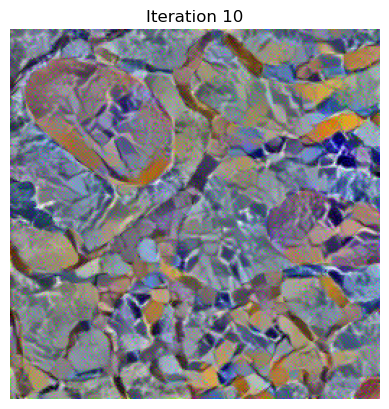

iteration 11
content_loss=104.08720397949219 style_loss=0.03272266313433647
content_loss=103.68550109863281 style_loss=0.03279847651720047
content_loss=103.59591674804688 style_loss=0.032588642090559006
content_loss=103.2206039428711 style_loss=0.03266804292798042
content_loss=103.05619812011719 style_loss=0.03249496966600418
content_loss=102.80033874511719 style_loss=0.03244643285870552
content_loss=102.5382080078125 style_loss=0.03239438682794571
content_loss=102.27619171142578 style_loss=0.03235602751374245
content_loss=102.0518569946289 style_loss=0.0322892963886261
content_loss=101.82144165039062 style_loss=0.03220810368657112
content_loss=101.5582275390625 style_loss=0.032163750380277634
content_loss=101.39359283447266 style_loss=0.032034121453762054
content_loss=101.14451599121094 style_loss=0.03199910372495651
content_loss=100.97210693359375 style_loss=0.031879376620054245
content_loss=100.58683776855469 style_loss=0.032012954354286194
content_loss=100.68677520751953 style_loss

In [8]:
imarray = np.random.rand(256, 256, 3) * 255
image_in = Image.fromarray(imarray.astype("uint8")).convert("RGB")

image_out = style_transfer(
    image=image_in,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    beta=1e3,
    iter_num=50,
)

plot_style_transform(content, style, image_out)

We then apply it using the content image as a starting point. Since in this case the input already has the content information, we can increase the value of the regularization parameter to `beta=1e5` and give more weight to the style loss. We also need less iterations to get to a reasonable results.

In [ ]:
image_out = style_transfer(
    image=content,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    beta=1e5,
    iter_num=50,
)

plot_style_transform(content, style, image_out)